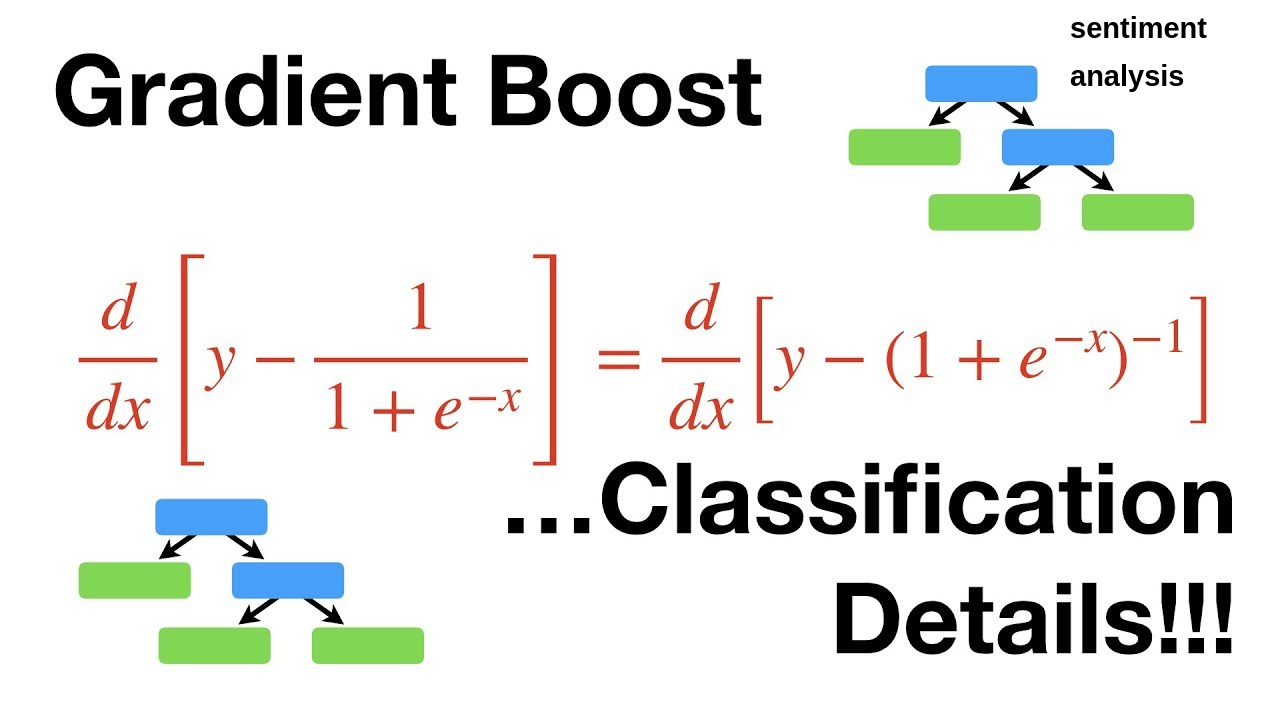

In [1]:
import os
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd

from pyspark.ml.feature import HashingTF, IDF, Tokenizer
import pickle  

In [2]:
## define a set of path: 
PATH = os.path.dirname(os.getcwd()) 
dataset_path = os.path.join(PATH, "dataset")
models_path = os.path.join(PATH, "models")

In [15]:
def load_data():
    data_path = os.path.join(dataset_path, "all_data.xlsx")
    data = pd.read_excel(data_path) 
    data_labels = data["labels"]  #Taking lables in separate
    print("data loaded")
    return data, data_labels

def tfidf(data):
    # corpus = pd.DataFrame({"reviews": train_data["reviews"], "lables": train_data["lables"]})
    # corpus.reviews.append(test_data["reviews"], ignore_index=True)
    corpus = data.copy()
    dataset = spark.createDataFrame(corpus, list(corpus.columns))

    tokenizer = Tokenizer(inputCol="reviews", outputCol="words")
    wordsData = tokenizer.transform(dataset)

    hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
    featurizedData = hashingTF.transform(wordsData)

    idf = IDF(inputCol="rawFeatures", outputCol="features")
    idfModel = idf.fit(featurizedData)
    rescaledData = idfModel.transform(featurizedData)
    features = rescaledData.select("features","labels")
    #save model 
    tfidf = os.path.join(models_path, "tfidf.pickle")
    pickle.dump(tfidf, open(tfidf, "wb"))
    print("tfidf model saved")
    return idfModel, features

def plot_score(model, x,y, x_label='params', y_label='score'):
    plt.figure(figsize=(9, 9))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x, y)
    title = 'result of learning using  {}'.format(model)
    plt.suptitle(title)
    plt.show()
    
def plot_score2(x_axis, y1, y2,title, xlabels, ylabels, y1title="training curve",y2title="testing curve",y1color='r',y2color='g'):
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabels)
    plt.ylabel(ylabels)
    plt.grid()
    plt.plot(x_axis, y1, 'o-', color=y1color, label= y1title)
    plt.plot(x_axis, y2, 'o-', color=y2color, label=y2title)
    plt.legend(loc="best")
    plt.show()

def plot_score3(x_axis, scores_train, title, xlabels, ylabels, ytitle="training score", y2color='g'):
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabels)
    plt.ylabel(ylabels)
    plt.grid()
    plt.plot(x_axis, scores_train, 'o-', color=y2color, label= ytitle)
    #plt.plot(x_axis, scores_test, 'o-', color=y2color, label=y2title)
    plt.legend(loc="best")
    plt.show()

In [4]:
"""
Load preprocessed data and use tfidf as a word embeding model
"""
data, data_labels = load_data()
idfModel, features= tfidf(data)
features.show() 

data loaded
tfidf model saved
+--------------------+------+
|            features|labels|
+--------------------+------+
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,2,3,4,5,6,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,2,3,4,5,6,...|     1|
|(20,[0,2,3,4,5,6,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,6,...|     1|
|(20,[0,3,4,6,7,8,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
|(20,[0,1,2,3,4,5,...|     1|
+--------------------+------+
only showing top 20 rows



In [6]:
from pyspark.ml.feature import VectorAssembler , StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.mllib.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

In [7]:
scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True, 
    withStd= True
    ).fit(features)

df_scaled = scaler.transform(features)
df_scaled.show(5)

+--------------------+------+--------------------+
|            features|labels|      scaledFeatures|
+--------------------+------+--------------------+
|(20,[0,1,2,3,4,5,...|     1|[-0.5050488895147...|
|(20,[0,1,2,3,4,5,...|     1|[0.62957021237823...|
|(20,[0,1,2,3,4,5,...|     1|[-0.0187835601320...|
|(20,[0,1,2,3,4,5,...|     1|[-0.8292257757698...|
|(20,[0,1,2,3,4,5,...|     1|[-0.5050488895147...|
+--------------------+------+--------------------+
only showing top 5 rows



In [8]:
result_pdf = df_scaled.select('scaledFeatures').toPandas().rename(columns={"scaledFeatures": "features"})
#result_pdf.head()
transformed = result_pdf.join(df_scaled.select('labels').toPandas())
#transformed.head()
transformed = spark.createDataFrame(transformed, list(transformed.columns))
transformed.show(5)

+--------------------+------+
|            features|labels|
+--------------------+------+
|[-0.5050488895147...|     1|
|[0.62957021237823...|     1|
|[-0.0187835601320...|     1|
|[-0.8292257757698...|     1|
|[-0.5050488895147...|     1|
+--------------------+------+
only showing top 5 rows



In [9]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='labels',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)


+--------------------+------+------------+
|            features|labels|indexedLabel|
+--------------------+------+------------+
|[-0.5050488895147...|     1|         1.0|
|[0.62957021237823...|     1|         1.0|
|[-0.0187835601320...|     1|         1.0|
|[-0.8292257757698...|     1|         1.0|
|[-0.5050488895147...|     1|         1.0|
+--------------------+------+------------+
only showing top 5 rows



In [10]:
"""

cols_name = ["labels", "features"]
#3- VectorAssembler:
vector_assembler = VectorAssembler(
      inputCols = list(cols_name), outputCol = 'features'
      )
df_temp1 = vector_assembler.transform(features).select('labels','features')
df_temp1.show(3)

#4- inexation
l_indexer = StringIndexer(inputCol="Class", outputCol="labelIndex")
df_temp2 = l_indexer.fit(df_temp1).transform(df_temp1)
df_temp2.show(3)

#5- selecting features/label columns
df_temp3 = df_temp2.select('features','labelIndex')
df_temp3.show(3)
"""

'\n\ncols_name = ["labels", "features"]\n#3- VectorAssembler:\nvector_assembler = VectorAssembler(\n      inputCols = list(cols_name), outputCol = \'features\'\n      )\ndf_temp1 = vector_assembler.transform(features).select(\'labels\',\'features\')\ndf_temp1.show(3)\n\n#4- inexation\nl_indexer = StringIndexer(inputCol="Class", outputCol="labelIndex")\ndf_temp2 = l_indexer.fit(df_temp1).transform(df_temp1)\ndf_temp2.show(3)\n\n#5- selecting features/label columns\ndf_temp3 = df_temp2.select(\'features\',\'labelIndex\')\ndf_temp3.show(3)\n'

In [11]:
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, True)

+--------------------+------+--------------------+
|            features|labels|     indexedFeatures|
+--------------------+------+--------------------+
|[-0.5050488895147...|     1|[-0.5050488895147...|
|[0.62957021237823...|     1|[0.62957021237823...|
|[-0.0187835601320...|     1|[-0.0187835601320...|
|[-0.8292257757698...|     1|[-0.8292257757698...|
|[-0.5050488895147...|     1|[-0.5050488895147...|
+--------------------+------+--------------------+
only showing top 5 rows



In [12]:
#spliting training and testing data + training
(trainingData, testData) = transformed.randomSplit([0.8, 0.2])
print("training data")
trainingData.show(5,True)
print("testing data")
testData.show(5,True)

training data
+--------------------+------+
|            features|labels|
+--------------------+------+
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
+--------------------+------+
only showing top 5 rows

testing data
+--------------------+------+
|            features|labels|
+--------------------+------+
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
|[-1.1534026620249...|     1|
+--------------------+------+
only showing top 5 rows



In [13]:
#@title random forest  model
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=labelIndexer.labels)

# Variation de maxDeep 

Test Error = 0.25111
train Error = 0.254895
Test Error = 0.256109
train Error = 0.250645
Test Error = 0.258308
train Error = 0.239244
Test Error = 0.24831
train Error = 0.231093
Test Error = 0.24791
train Error = 0.223792
Test Error = 0.242511
train Error = 0.206791
Test Error = 0.245711
train Error = 0.190389
Test Error = 0.25031
train Error = 0.175638
Test Error = 0.243711
train Error = 0.151735
Test Error = 0.254109
train Error = 0.127583
Test Error = 0.254509
train Error = 0.106131
Test Error = 0.260308
train Error = 0.0844284
Test Error = 0.261308
train Error = 0.0639764
Test Error = 0.262907
train Error = 0.0449745
Test Error = 0.259908
train Error = 0.0247725
Test Error = 0.263907
train Error = 0.0117212


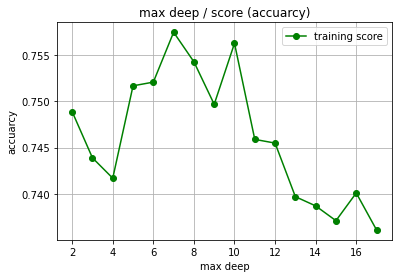

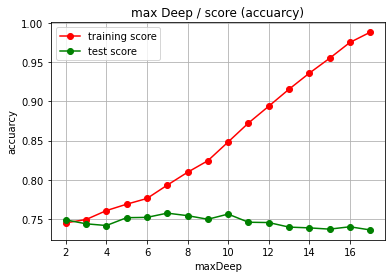

RandomForestClassificationModel: uid=RandomForestClassifier_23dd1ddd6f5e, numTrees=2, numClasses=2, numFeatures=20


In [47]:
#@title training and evaluation   
scores_trainig = []
scores_tresting = []
features_var = []


featureSubsetStrategy= "auto" #@param {type:"string"}
impurity = "gini" #@param {type:"string"}
seed =  36 #@param {type:"integer"}
#maxDepth = 9 #@param {type:"integer"}
maxBins = 32 #@param {type:"integer"}
numTrees= 2 #@param {type:"integer"}

for maxDepth in range(2,18):
    rf = RandomForestClassifier(labelCol="labels", featuresCol="features", impurity=impurity, numTrees=numTrees, maxDepth=maxDepth, seed=seed, maxBins=maxBins)
    pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

    # Train model.  This also runs the indexers.
    model = pipeline.fit(trainingData)

    # Make predictions with testing data
    predictions = model.transform(testData)
    #predictions.select("predictedLabel", "labels",'probability', "features").show(5)
    # Select (prediction, true label) and compute test error
    evaluator_test = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
    accuracy_test = evaluator_test.evaluate(predictions)
    print("Test Error = %g" % (1.0 - accuracy_test))
    
    # Make predictions with training data.
    predictions = model.transform(trainingData)
    evaluator_train = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
    accuracy_train = evaluator_train.evaluate(predictions)
        
    print("train Error = %g" % (1.0 - accuracy_train))
    features_var.append(maxDepth)
    scores_tresting.append(accuracy_test)
    scores_trainig.append(accuracy_train)


plot_score3(features_var, scores_tresting, title="max deep / score (accuarcy)", xlabels='max deep', ylabels='accuarcy', ytitle="training score")
plot_score2(features_var, scores_trainig, scores_tresting,title="max Deep / score (accuarcy)", xlabels='maxDeep', ylabels='accuarcy', y1title="training score",y2title="test score",y1color='r',y2color='g')

rfModel = model.stages[2]
print(rfModel)  # summary only


# Variation de maxBins 

Test Error = 0.257708
train Error = 0.223192
Test Error = 0.242711
train Error = 0.214841
Test Error = 0.256109
train Error = 0.20419
Test Error = 0.238112
train Error = 0.20204
Test Error = 0.25091
train Error = 0.213141
Test Error = 0.24891
train Error = 0.19819
Test Error = 0.233713
train Error = 0.19824
Test Error = 0.240512
train Error = 0.20074
Test Error = 0.241912
train Error = 0.19814
Test Error = 0.24911
train Error = 0.20154
Test Error = 0.265307
train Error = 0.19764
Test Error = 0.257908
train Error = 0.19834
Test Error = 0.239312
train Error = 0.19694
Test Error = 0.238512
train Error = 0.19659
Test Error = 0.240912
train Error = 0.19774
Test Error = 0.245511
train Error = 0.19874
Test Error = 0.243911
train Error = 0.19699
Test Error = 0.24991
train Error = 0.19859


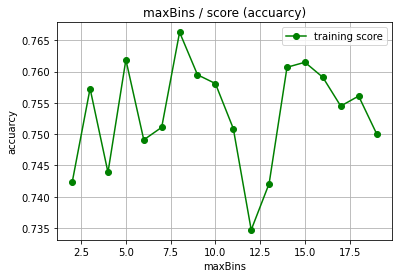

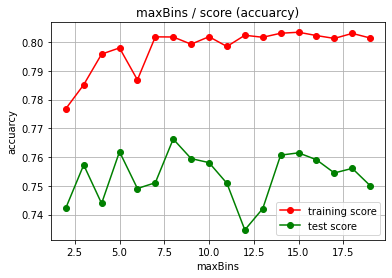

RandomForestClassificationModel: uid=RandomForestClassifier_6e37c1716898, numTrees=2, numClasses=2, numFeatures=20


In [50]:
#@title training and evaluation   
scores_trainig = []
scores_tresting = []
features_var = []


featureSubsetStrategy= "auto" #@param {type:"string"}
impurity = "gini" #@param {type:"string"}
seed =  36 #@param {type:"integer"}
maxDepth = 8 #@param {type:"integer"}
#maxBins = 32 #@param {type:"integer"}
numTrees= 2 #@param {type:"integer"}

for maxBins in range(2,20):
    rf = RandomForestClassifier(labelCol="labels", featuresCol="features", impurity=impurity, numTrees=numTrees, maxDepth=maxDepth, seed=seed, maxBins=maxBins)
    pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

    # Train model.  This also runs the indexers.
    model = pipeline.fit(trainingData)

    # Make predictions.
    predictions = model.transform(testData)
    #predictions.select("predictedLabel", "labels",'probability', "features").show(5)
    # Select (prediction, true label) and compute test error
    evaluator_test = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
    accuracy_test = evaluator_test.evaluate(predictions)
    print("Test Error = %g" % (1.0 - accuracy_test))
    
    # Make predictions with training data.
    predictions = model.transform(trainingData)
    evaluator_train = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
    accuracy_train = evaluator_train.evaluate(predictions)
        
    print("train Error = %g" % (1.0 - accuracy_train))
    features_var.append(maxBins)
    scores_tresting.append(accuracy_test)
    scores_trainig.append(accuracy_train)
    
    # Select (prediction, true label) and compute test error
    #evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
    #accuracy = evaluator.evaluate(predictions)
    #print("Test Error = %g" % (1.0 - accuracy))
    #features_var.append(maxBins)
    #scores_tresting.append(accuracy)


plot_score3(features_var, scores_tresting, title="maxBins / score (accuarcy)", xlabels='maxBins', ylabels='accuarcy', ytitle="training score")
plot_score2(features_var, scores_trainig, scores_tresting,title="maxBins / score (accuarcy)", xlabels='maxBins', ylabels='accuarcy', y1title="training score",y2title="test score",y1color='r',y2color='g')

rfModel = model.stages[2]
print(rfModel)  # summary only


# Variation de numTrees 

Test Error = 0.255909
train Error = 0.20284
Test Error = 0.245711
train Error = 0.190389
Test Error = 0.229114
train Error = 0.180638
Test Error = 0.237313
train Error = 0.171287
Test Error = 0.233713
train Error = 0.164136
Test Error = 0.237912
train Error = 0.155486
Test Error = 0.225715
train Error = 0.154085
Test Error = 0.219316
train Error = 0.142684
Test Error = 0.217516
train Error = 0.142684
Test Error = 0.222515
train Error = 0.137134
Test Error = 0.221716
train Error = 0.143484
Test Error = 0.220716
train Error = 0.137434
Test Error = 0.216117
train Error = 0.137984
Test Error = 0.211318
train Error = 0.131633
Test Error = 0.211518
train Error = 0.136034
Test Error = 0.217716
train Error = 0.126983
Test Error = 0.219716
train Error = 0.135484
Test Error = 0.211518
train Error = 0.129633
Test Error = 0.207518
train Error = 0.126333


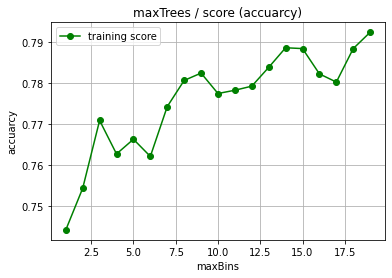

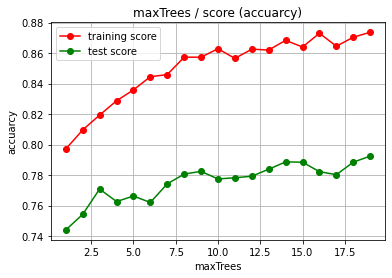

RandomForestClassificationModel: uid=RandomForestClassifier_6d0c30bf2207, numTrees=19, numClasses=2, numFeatures=20


In [56]:
#@title training and evaluation   
scores_trainig = []
scores_tresting = []
features_var = []

featureSubsetStrategy= "auto" #@param {type:"string"}
impurity = "gini" #@param {type:"string"}
seed =  36 #@param {type:"integer"}
maxDepth = 8 #@param {type:"integer"}
maxBins = 32 #@param {type:"integer"}
#numTrees= 2 #@param {type:"integer"}


for numTrees in range(1,20):
    rf = RandomForestClassifier(labelCol="labels", featuresCol="features", impurity=impurity, numTrees=numTrees, maxDepth=maxDepth, seed=seed, maxBins=maxBins)
    pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

    # Train model.  This also runs the indexers.
    model = pipeline.fit(trainingData)
    
    predictions = model.transform(testData)
    #predictions.select("predictedLabel", "labels",'probability', "features").show(5)
    # Select (prediction, true label) and compute test error
    evaluator_test = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
    accuracy_test = evaluator_test.evaluate(predictions)
    print("Test Error = %g" % (1.0 - accuracy_test))
    
    # Make predictions with training data.
    predictions = model.transform(trainingData)
    evaluator_train = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
    accuracy_train = evaluator_train.evaluate(predictions)
        
    print("train Error = %g" % (1.0 - accuracy_train))
    features_var.append(numTrees)
    scores_tresting.append(accuracy_test)
    scores_trainig.append(accuracy_train)
    
    # Make predictions.
    #predictions = model.transform(testData)
    #predictions.select("predictedLabel", "labels",'probability', "features").show(5)

    # Select (prediction, true label) and compute test error
    #evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
    #accuracy = evaluator.evaluate(predictions)
    #print("Test Error = %g" % (1.0 - accuracy))
    #features_var.append(numTrees)
    #scores.append(accuracy)


plot_score3(features_var, scores_tresting, title="maxTrees / score (accuarcy)", xlabels='maxBins', ylabels='accuarcy', ytitle="training score")
plot_score2(features_var, scores_trainig, scores_tresting,title="maxTrees / score (accuarcy)", xlabels='maxTrees', ylabels='accuarcy', y1title="training score",y2title="test score",y1color='r',y2color='g')
rfModel = model.stages[2]
print(rfModel)  # summary only


# vairation of  3 hyper params 

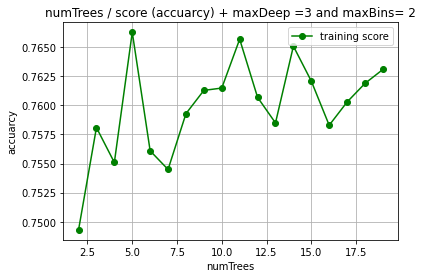

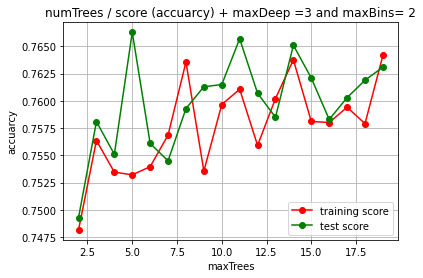

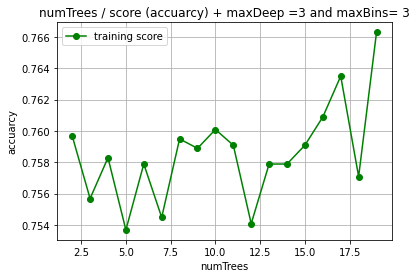

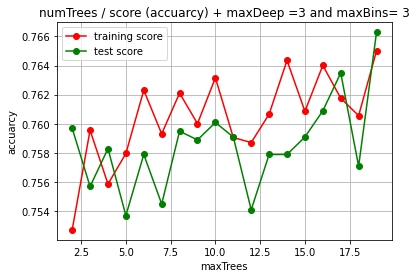

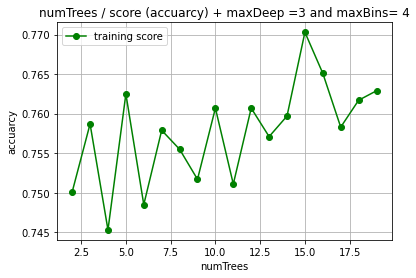

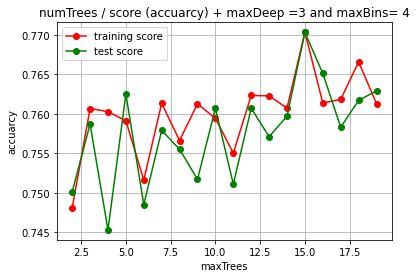

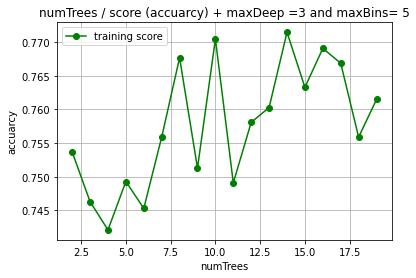

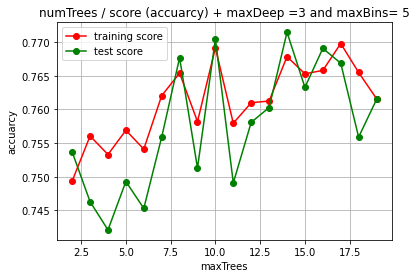

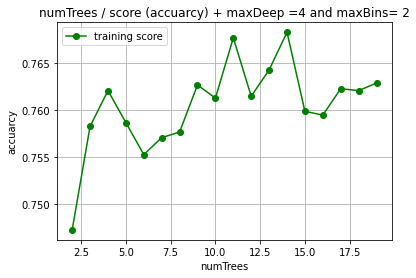

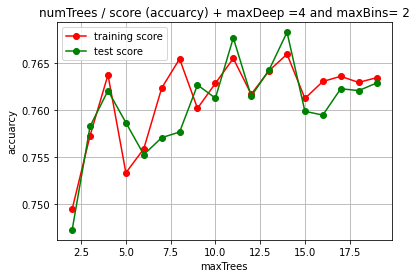

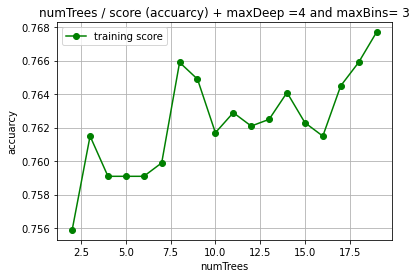

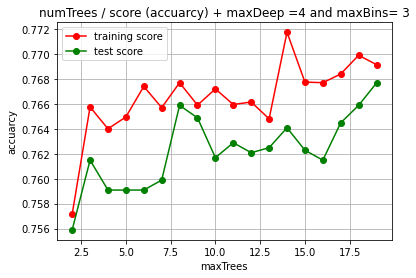

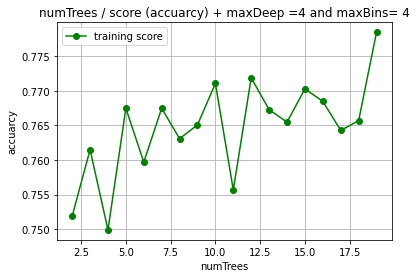

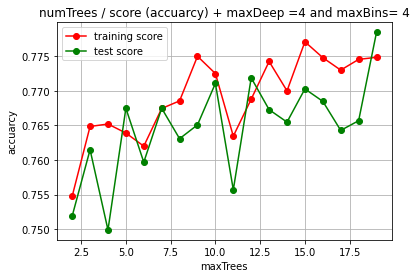

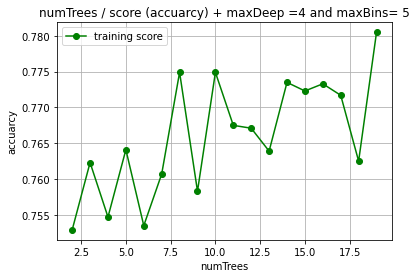

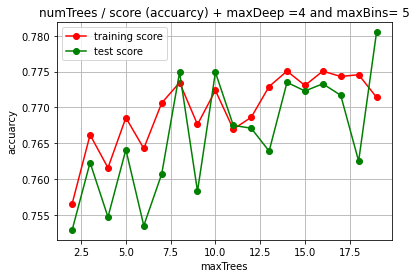

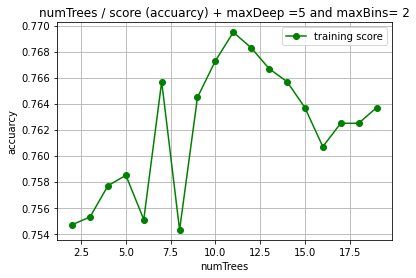

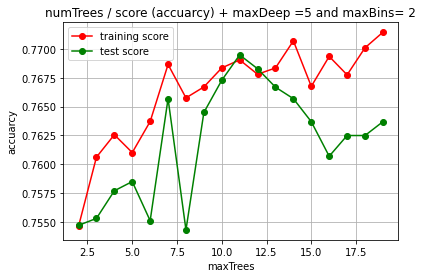

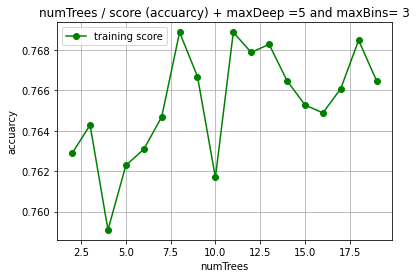

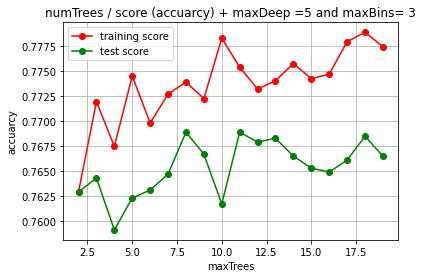

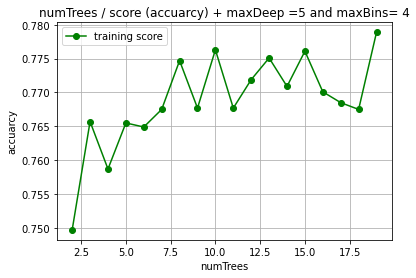

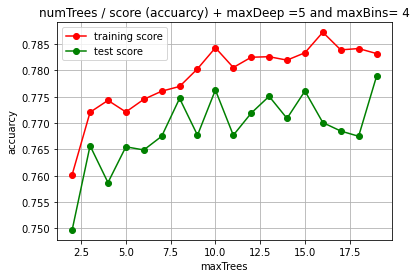

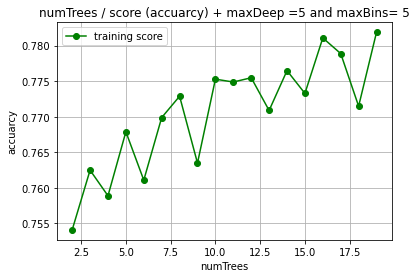

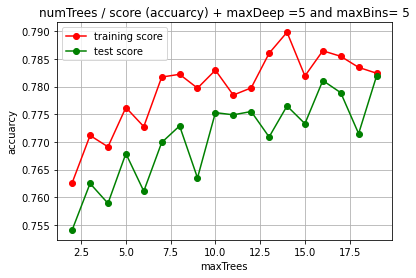

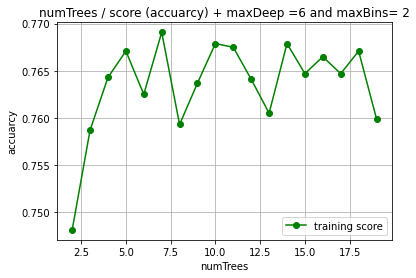

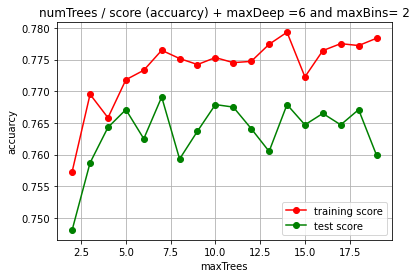

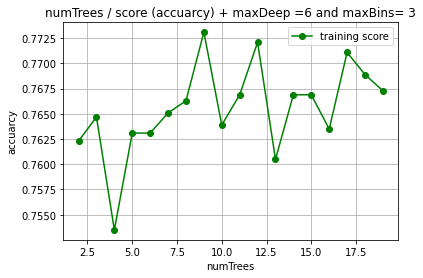

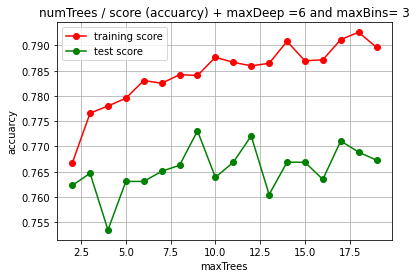

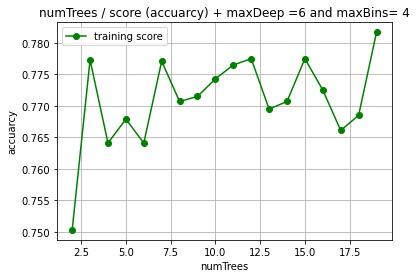

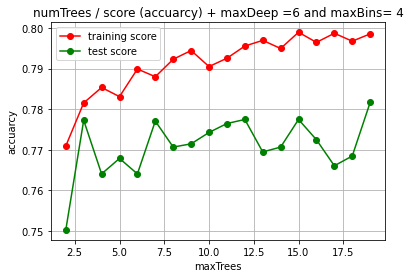

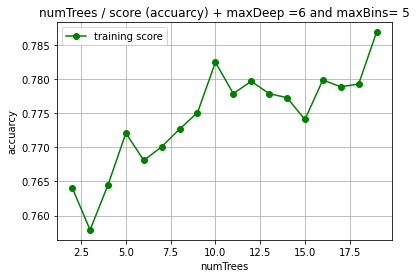

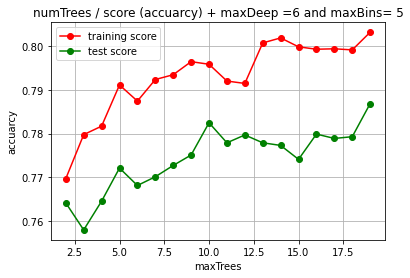

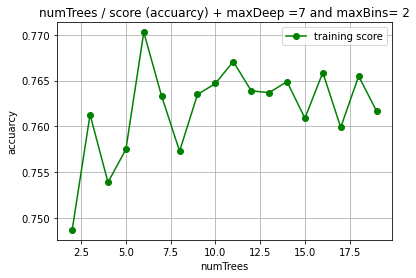

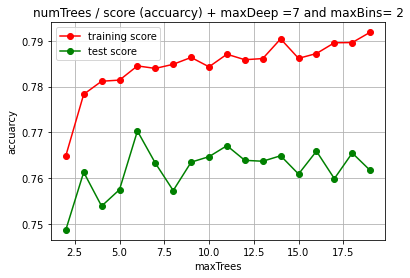

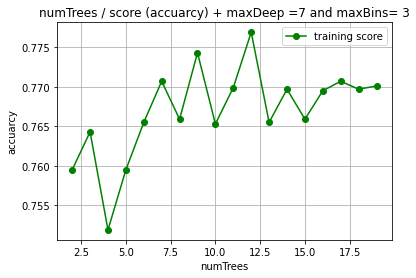

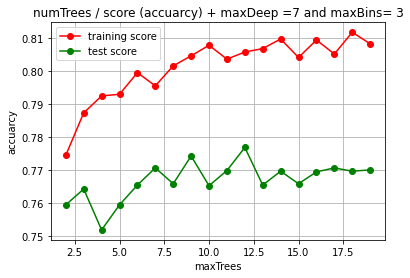

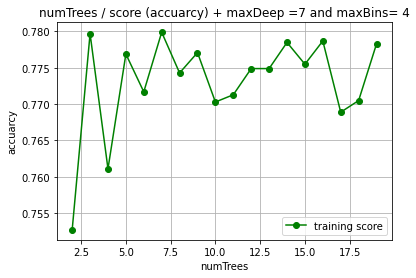

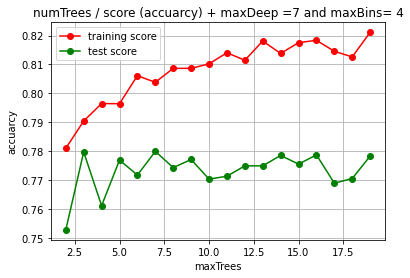

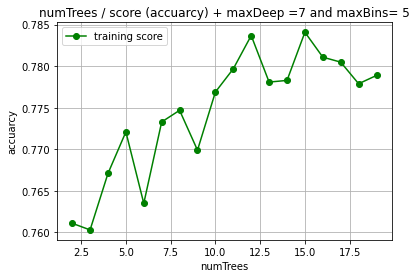

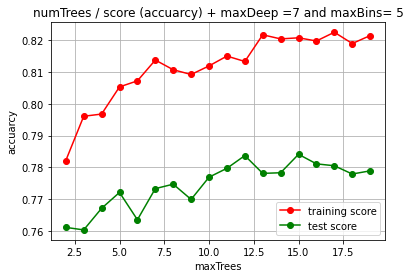

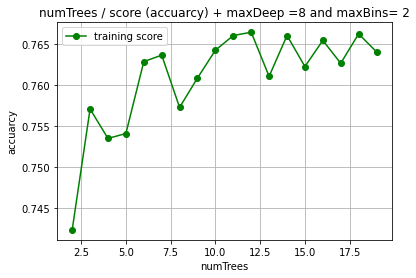

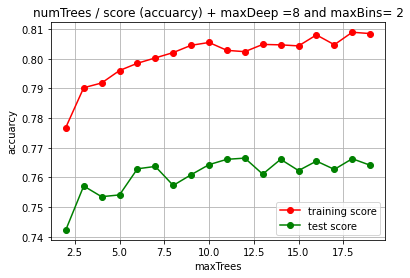

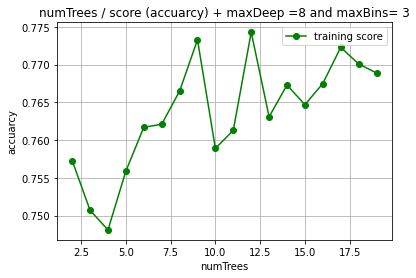

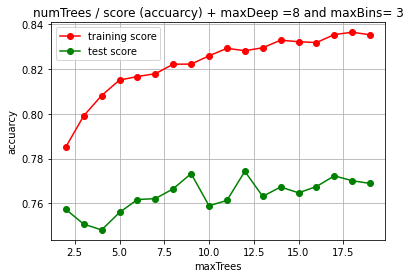

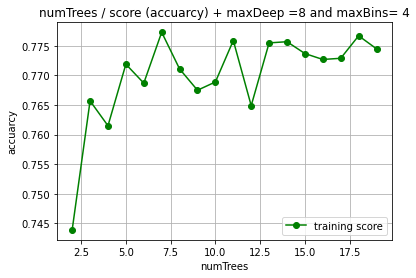

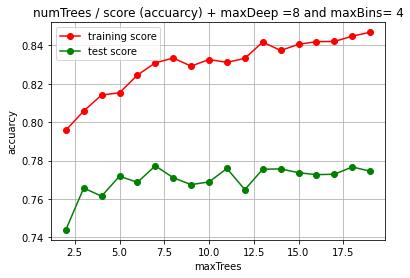

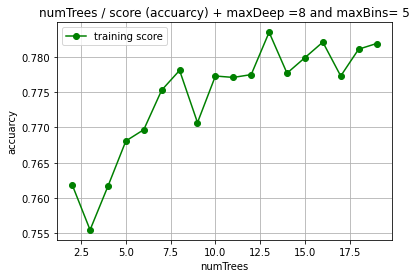

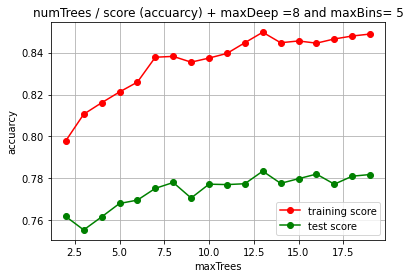

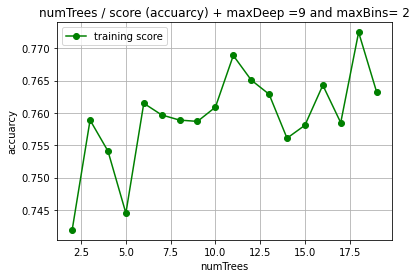

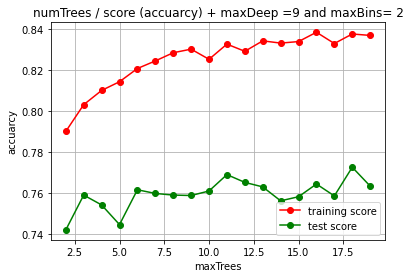

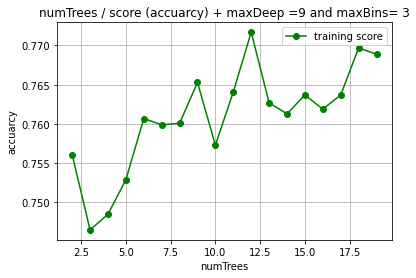

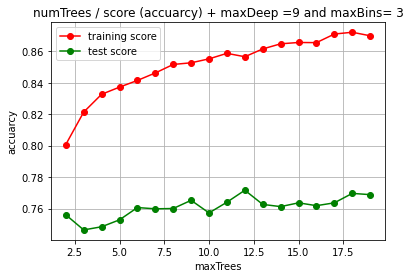

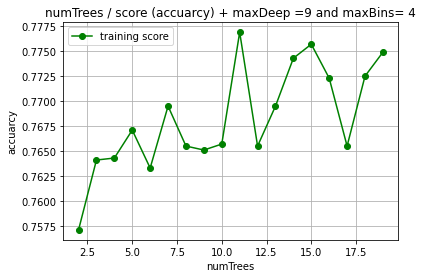

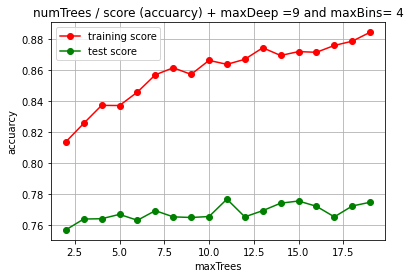

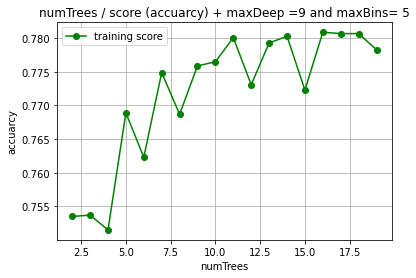

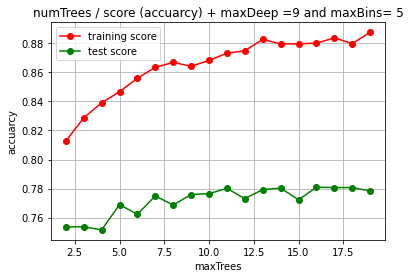

RandomForestClassificationModel: uid=RandomForestClassifier_f81fb9a2836c, numTrees=19, numClasses=2, numFeatures=20


In [58]:
#@title training and evaluation   
#scores = []
#features_var = []

featureSubsetStrategy= "auto" #@param {type:"string"}
impurity = "gini" #@param {type:"string"}
seed =  36 #@param {type:"integer"}
#maxDepth = 8 #@param {type:"integer"}
#maxBins = 32 #@param {type:"integer"}
#numTrees= 2 #@param {type:"integer"}


for maxDepth in range(3,10):
    for maxBins in range(2,6):
        scores_trainig = []
        scores_tresting = []
        features_var = []
        for numTrees in range(2,20):
            rf = RandomForestClassifier(labelCol="labels", featuresCol="features", impurity=impurity, numTrees=numTrees, maxDepth=maxDepth, seed=seed, maxBins=maxBins)
            pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

            # Train model.  This also runs the indexers.
            model = pipeline.fit(trainingData)

            # Make predictions.
            predictions = model.transform(testData)
            #predictions.select("predictedLabel", "labels",'probability', "features").show(5)
            # Select (prediction, true label) and compute test error
            evaluator_test = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
            accuracy_test = evaluator_test.evaluate(predictions)
            #print("Test Error = %g" % (1.0 - accuracy_test))

            # Make predictions with training data.
            predictions = model.transform(trainingData)
            evaluator_train = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
            accuracy_train = evaluator_train.evaluate(predictions) 

            #print("train Error = %g" % (1.0 - accuracy_train))
            features_var.append(numTrees)
            scores_tresting.append(accuracy_test)
            scores_trainig.append(accuracy_train)


        plot_score3(features_var, scores_tresting, title="numTrees / score (accuarcy) + maxDeep ={} and maxBins= {}".format(maxDepth, maxBins), xlabels='numTrees', ylabels='accuarcy', ytitle="training score")
        plot_score2(features_var, scores_trainig, scores_tresting,title="numTrees / score (accuarcy) + maxDeep ={} and maxBins= {}".format(maxDepth, maxBins), xlabels='maxTrees', ylabels='accuarcy', y1title="training score",y2title="test score",y1color='r',y2color='g')


rfModel = model.stages[2]
print(rfModel)  # summary only


# Choose hyper params for gradient boosting

In [62]:
#@title training and evaluation 
featureSubsetStrategy= "auto" #@param {type:"string"}
impurity = "gini" #@param {type:"string"}
seed =  36 #@param {type:"integer"}
maxDepth = 9 #@param {type:"integer"}
maxBins = 5 #@param {type:"integer"}
numTrees= 5 #@param {type:"integer"}



rf = RandomForestClassifier(labelCol="labels", featuresCol="features", impurity=impurity, numTrees=numTrees, maxDepth=maxDepth, seed=seed, maxBins=maxBins)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])




# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

predictions.show(2)

predictions.select("predictedLabel", "labels",'probability', "features").show(2)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions) 
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------------+------+------------+--------------------+--------------------+--------------------+----------+--------------+
|            features|labels|indexedLabel|     indexedFeatures|       rawPrediction|         probability|prediction|predictedLabel|
+--------------------+------+------------+--------------------+--------------------+--------------------+----------+--------------+
|[-1.1534026620249...|     1|         1.0|[-1.1534026620249...|[2.22965086463013...|[0.44593017292602...|       1.0|             1|
|[-1.1534026620249...|     1|         1.0|[-1.1534026620249...|[2.18126801687749...|[0.43625360337549...|       1.0|             1|
+--------------------+------+------------+--------------------+--------------------+--------------------+----------+--------------+
only showing top 2 rows

+--------------+------+--------------------+--------------------+
|predictedLabel|labels|         probability|            features|
+--------------+------+--------------------+-------